In [22]:
import time
import tracemalloc
import copy
import networkx as nx

In [23]:
def louvain_algorithm(G, delta_q=0.5, time_limit=None):
    """
    Args:
        G: NetworkX graph
        delta_q: Minimum modularity gain threshold to accept a move (default: 0.001) the smaller the number the more communities
        time_limit: time limit in seconds to capture intermediate state
        
    Returns:
        dict: Contains 'communities', 'execution_time', 'memory_used', 
              and optionally 'graph_at_time_limit' if time_limit is specified
    """
    # Start tracking time and memory
    start_time = time.time()
    tracemalloc.start()
    
    # Statistics for testing 
    stats = {
        'modularity_calculations': 0,
        'node_moves': 0,
        'phases': 0,
        'iterations': 0
    }
    
    # Variables for time limit tracking
    intermediate_state = None
    time_limit_reached = False
    
    # Start with each node in its own community
    node_to_community = {node: node for node in G.nodes()}
    
    # Calculate total weight of graph (for modularity)
    m = G.size(weight='weight')
    if m == 0:  # Handle graph with no edge weights 
        m = len(G.edges())  # If graph has no edge weights then all edges have weight 1

    # Actual algorithm begins
    improved = True
    
    # Keep going until no improvement
    while improved:
        stats['phases'] += 1
        improved = False
        moved_any = False
        
        # Phase 1: Move nodes to optimize modularity
        changed = True
        while changed:
            stats['iterations'] += 1
            changed = False
            
            # Check if time limit reached
            if time_limit and not time_limit_reached:
                elapsed = time.time() - start_time
                if elapsed >= time_limit:
                    time_limit_reached = True
                    # Save intermediate state
                    intermediate_state = {
                        'node_to_community': copy.deepcopy(node_to_community),
                        'elapsed_time': elapsed
                    }
            
            # Try moving each node to a better community
            for node in G.nodes():
                current_comm = node_to_community[node]
                
                # Calculate current node's degree
                node_degree = G.degree(node, weight='weight')
                
                # Find neighboring communities
                neighbor_comms = set()
                for neighbor in G.neighbors(node):
                    neighbor_comms.add(node_to_community[neighbor])
                
                # Also consider the current community
                neighbor_comms.add(current_comm)
                
                # Find best community for this node
                best_comm = current_comm
                best_gain = 0
                
                for comm in neighbor_comms:
                    # Calculate modularity gain if we move to this community
                    gain = calculate_modularity_gain(G, node, comm, node_to_community, m)
                    #print(m)
                    #print("gain" + str(gain))
                    stats['modularity_calculations'] += 1
                    
                    if gain > best_gain:
                        best_gain = gain
                        best_comm = comm
                
                # Move node if we found a better community and gain exceeds delta_q
                if best_comm != current_comm and best_gain > delta_q:
                    node_to_community[node] = best_comm
                    changed = True
                    moved_any = True 
                    stats['node_moves'] += 1

        if not moved_any:
            improved = True            
        
        # Uncomment to enable Phase 2 (hierarchical aggregation)
        """
        # Phase 2: Build a new graph where each community becomes a node (aggregation) 
        if improved:
            G = build_community_graph(G, node_to_community)
            # Update node_to_community for the new graph
            node_to_community = {node: node for node in G.nodes()}
        """
    
    # Stop tracking time and memory
    execution_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    # Convert to KB for better precision with small memory usage
    memory_used_kb = peak / 1024
    
    # Convert final node_to_community to the requested format
    communities = {}
    for node, comm in node_to_community.items():
        if comm not in communities:
            communities[comm] = []
        communities[comm].append(node)
    
    # Prepare result dictionary
    result = {
        'communities': communities,
        'execution_time': execution_time,
        'memory_used_kb': memory_used_kb,  # Memory in KB
        'memory_used_bytes': peak,  # Also provide raw bytes
        'stats': stats
    }
    
    # Add intermediate state if time limit was specified and reached
    if time_limit and intermediate_state:
        # Convert intermediate node_to_community to communities format
        intermediate_communities = {}
        for node, comm in intermediate_state['node_to_community'].items():
            if comm not in intermediate_communities:
                intermediate_communities[comm] = []
            intermediate_communities[comm].append(node)
        
        result['graph_at_time_limit'] = {
            'communities': intermediate_communities,
            'elapsed_time': intermediate_state['elapsed_time']
        }
    
    return result


def calculate_modularity_gain(G, node, target_comm, node_to_community, m):
    """
    Calculate the modularity gain from moving a node to a target community.
    
    Args:
        G: NetworkX graph
        node: The node to potentially move
        target_comm: The community we're considering moving to
        node_to_community: Current mapping of nodes to communities
        m: Total weight of all edges in graph
        
    Returns:
        The modularity gain (can be negative)
    """
    # Calculate edges from node to target community
    ki_in = 0  # edges from node to nodes in target_comm
    for neighbor in G.neighbors(node):
        if node_to_community[neighbor] == target_comm:
            weight = G[node][neighbor].get('weight', 1)
            ki_in += weight

    #print("this is ki_in " + str(ki_in))
    
    # Calculate total degree of nodes in target community (excluding node if it's in there)
    sigma_tot = 0
    for n in G.nodes():
        if node_to_community[n] == target_comm and n != node:
            sigma_tot += G.degree(n, weight='weight')

    #print("this is tot " + str(sigma_tot))
    
    # Node's degree
    ki = G.degree(node, weight='weight')

    #print("this is ki " + str(ki))
    
    # Modularity gain formula
    # Δ Q = [ki_in / (2m)] - [(sigma_tot * ki) / (2m)²]
    # Simplified: Δ Q = [ki_in - (sigma_tot * ki) / (2m)] / m
    # gain = 2 * ki_in - (sigma_tot * ki) / m  #(2 * m)) / m
    if m != 0: 
        gain = (ki_in - (sigma_tot * ki) / (2 * m))
    else: 
        gain = (ki_in - (sigma_tot * ki) / (2 * 0.001)); 
    #print(gain)
    
    return gain


def build_community_graph(G, node_to_community):
    """
    Build a new graph where each community becomes a single node.
    Edges between communities are weighted by the sum of edges between their members.
    
    Args:
        G: Original graph
        node_to_community: Mapping of nodes to communities
        
    Returns:
        A new NetworkX graph where nodes represent communities
    """
    # Create new graph
    new_G = nx.Graph()
    
    # Get unique communities
    communities = set(node_to_community.values())
    new_G.add_nodes_from(communities)
    
    # Add edges between communities
    for u, v in G.edges():
        comm_u = node_to_community[u]
        comm_v = node_to_community[v]
        weight = G[u][v].get('weight', 1)
        
        if comm_u == comm_v:
            # Self-loop in the new graph
            if new_G.has_edge(comm_u, comm_u):
                new_G[comm_u][comm_u]['weight'] += weight
            else:
                new_G.add_edge(comm_u, comm_u, weight=weight)
        else:
            # Edge between different communities
            if new_G.has_edge(comm_u, comm_v):
                new_G[comm_u][comm_v]['weight'] += weight
            else:
                new_G.add_edge(comm_u, comm_v, weight=weight)
    
    return new_G

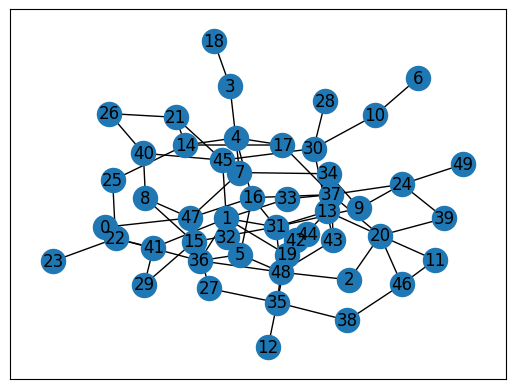

In [51]:
G = nx.gnp_random_graph(n=50, p=0.05)
l = nx.kamada_kawai_layout(G)
nx.draw_networkx(G, pos=l)

In [52]:
# Run with delta_q threshold
result = louvain_algorithm(G, time_limit=0.3)

communities = result['communities']
for community_id, nodes in communities.items():
    print(f"Community {community_id}: {nodes}")

print(f"Execution Time: {result['execution_time']:.4f} seconds")
print(f"Memory Used: {result['memory_used_kb']:.2f} KB ({result['memory_used_bytes']} bytes)")
print(f"Number of Communities: {len(result['communities'])}")
print(f"Statistics: {result['stats']}")
print(result['communities'])

if 'graph_at_time_limit' in result:
    print(f"\nIntermediate state at {result['graph_at_time_limit']['elapsed_time']:.4f}s:")
    print(f"Communities at time limit: {len(result['graph_at_time_limit']['communities'])}")
    communities = result['graph_at_time_limit']['communities']
    for community_id, nodes in communities.items():
        print(f"Community {community_id}: {nodes}")

Community 47: [0, 16, 47]
Community 33: [1, 19, 33]
Community 46: [2, 11, 20, 46]
Community 18: [3, 18]
Community 25: [4, 14, 17]
Community 36: [5, 36, 48]
Community 10: [6, 10]
Community 34: [7, 34]
Community 40: [8, 26, 40]
Community 24: [9, 31]
Community 35: [12, 27, 35, 38]
Community 43: [13, 43]
Community 41: [15, 29, 41]
Community 26: [21, 45]
Community 23: [22, 23, 25]
Community 49: [24, 37, 39, 49]
Community 30: [28, 30]
Community 32: [32]
Community 42: [42]
Community 44: [44]
Execution Time: 0.0200 seconds
Memory Used: 5.42 KB (5551 bytes)
Number of Communities: 20
Statistics: {'modularity_calculations': 438, 'node_moves': 39, 'phases': 1, 'iterations': 3}
{47: [0, 16, 47], 33: [1, 19, 33], 46: [2, 11, 20, 46], 18: [3, 18], 25: [4, 14, 17], 36: [5, 36, 48], 10: [6, 10], 34: [7, 34], 40: [8, 26, 40], 24: [9, 31], 35: [12, 27, 35, 38], 43: [13, 43], 41: [15, 29, 41], 26: [21, 45], 23: [22, 23, 25], 49: [24, 37, 39, 49], 30: [28, 30], 32: [32], 42: [42], 44: [44]}


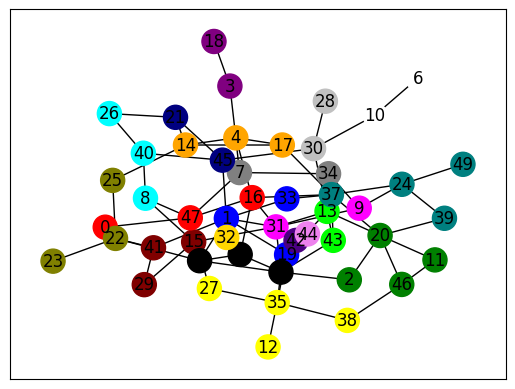

In [53]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'white', 'gray', 'cyan', 'magenta', 'yellow', 'lime', 'maroon', 'navy', 'olive', 'teal', 'silver', 'gold', 'indigo', 'violet', 'pink', 'brown', 'beige', 'turquoise', 'lavender', 'salmon', 'chocolate', 'orchid', 'plum', 'peru', 'sienna', 'khaki', 'coral', 'crimson', 'azure', 'aliceblue', 'antiquewhite', 'aquamarine', 'bisque', 'blanchedalmond', 'blueviolet', 'burlywood', 'cadetblue', 'chartreuse', 'cornflowerblue', 'cornsilk', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'fuchsia', 'gainsboro', 'ghostwhite', 'goldenrod', 'greenyellow', 'honeydew', 'hotpink', 'indianred', 'ivory', 'lavenderblush', 'lawngreen', 'lemonchiffon', 'lightblue', 'lightcoral', 'lightcyan', 'lightgoldenrodyellow', 'lightgray', 'lightgreen', 'lightpink', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'lightyellow', 'limegreen', 'linen', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'midnightblue', 'mintcream', 'mistyrose', 'moccasin', 'navajowhite', 'oldlace', 'olivedrab', 'orangered', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'papayawhip', 'peachpuff', 'powderblue', 'rosybrown', 'royalblue', 'saddlebrown', 'seagreen', 'seashell', 'sienna', 'skyblue', 'slateblue', 'slategray', 'snow', 'springgreen', 'steelblue', 'tan', 'thistle', 'tomato', 'transparent', 'wheat', 'whitesmoke', 'yellowgreen']
i = 0
for value in result['communities'].values():
    nodes = value
    for n in nodes:
        G.nodes[n]['color']=colors[i] 

    i += 1

node_colors = [G.nodes[node].get('color') for node in G.nodes()]
nx.draw_networkx(G,pos = l, node_color=node_colors)
    

In [28]:
import matplotlib.pyplot as plt
import math

numbers = list(range(10,300,20))
comps = []
times = []

for ns in numbers: 
    g = nx.gnp_random_graph(n=ns, p=0.25)
    result = louvain_algorithm(g)
    comps.append(result['stats']['modularity_calculations'])
    times.append(result['execution_time'])

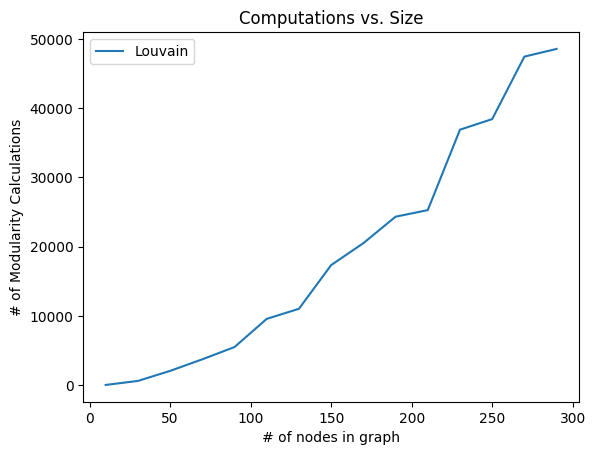

In [29]:
plt.plot(numbers, sorted(comps), label = 'Louvain')
plt.ylabel("# of Modularity Calculations")
plt.xlabel("# of nodes in graph")
plt.title("Computations vs. Size")
plt.legend()
plt.show()

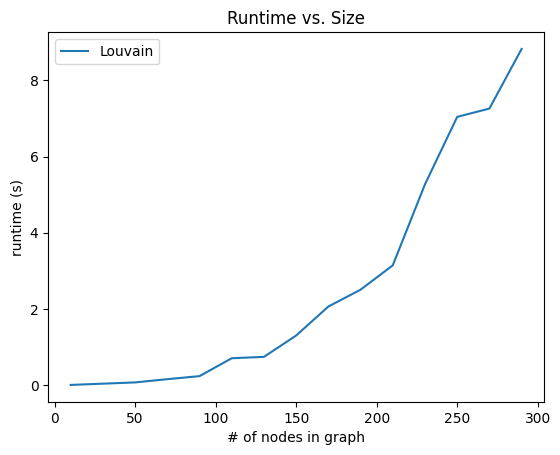

In [54]:
plt.plot(numbers, sorted(times), label = 'Louvain')
plt.ylabel("runtime (s)")
plt.xlabel("# of nodes in graph")
plt.title("Runtime vs. Size")
plt.legend()
plt.show()

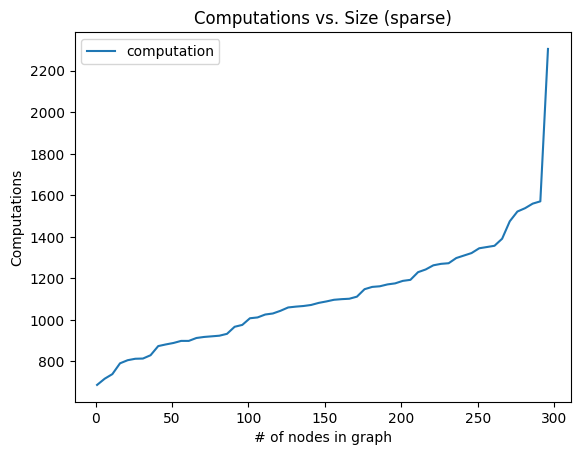

In [74]:
import matplotlib.pyplot as plt
import math

numbers = list(range(1,300,5))
comps = []
times = []
edges =[]

for ns in numbers: 
    g = nx.gnp_random_graph(n=50, p=0.1)
    result = louvain_algorithm(g)
    comps.append(result['stats']['modularity_calculations'])
    times.append(result['execution_time'])
    edges.append(len(g.edges()))
    
plt.plot(numbers, sorted(comps), label = 'computation')
plt.ylabel("Computations")
plt.xlabel("# of nodes in graph")
plt.title("Computations vs. Size (sparse)")
plt.legend()
plt.show()

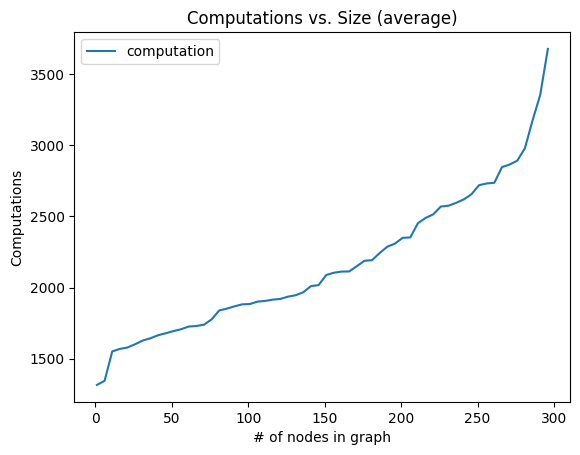

In [75]:
import matplotlib.pyplot as plt
import math

numbers = list(range(1,300,5))
comps = []
times = []
edges =[]

for ns in numbers: 
    g = nx.gnp_random_graph(n=50, p=0.5)
    result = louvain_algorithm(g)
    comps.append(result['stats']['modularity_calculations'])
    times.append(result['execution_time'])
    edges.append(len(g.edges()))

plt.plot(numbers, sorted(comps), label = 'computation')
plt.ylabel("Computations")
plt.xlabel("# of nodes in graph")
plt.title("Computations vs. Size (average)")
plt.legend()
plt.show()

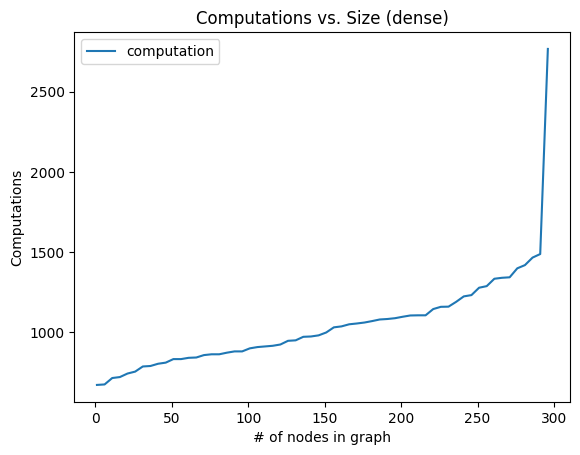

In [87]:
import matplotlib.pyplot as plt
import math

numbers = list(range(1,300,5))
comps = []
times = []
edges =[]

for ns in numbers: 
    g = nx.gnp_random_graph(n=50, p=0.1)
    result = louvain_algorithm(g)
    comps.append(result['stats']['modularity_calculations'])
    times.append(result['execution_time'])
    edges.append(len(g.edges()))

plt.plot(numbers, sorted(comps), label = 'computation')
plt.ylabel("Computations")
plt.xlabel("# of nodes in graph")
plt.title("Computations vs. Size (dense)")
plt.legend()
plt.show()